#**Data Cleaning with Python**

## Origen de Datos

A continuación crearemos un dataset "sucio", con la ayuda de las libreríás ***faker*** y ***random***.

El siguiente código contendrá los siguientes errores que tendremos que detectar:
- Ids duplicados
- Nombres nulos (2%)
- Valores atípicos
- Ciudades nulas, cantidad aleatoria.
- Fechas nulas (5%)
- Categoría nula
- Normalización de cadenas de texto
- Conversión de fechas

El resultado se guardará en un csv "dataset_sucio.csv"


###Importar Librerías

In [20]:
%%capture
!pip install fake
import pandas as pd
import numpy as np
from faker import Faker
import random
import seaborn as sns
import matplotlib.pyplot as plt

###Generación del Dataset

In [19]:
# Inicializar Faker para generar datos aleatorios
fake = Faker("es_ES")

# Configuración de aleatoriedad para reproducibilidad
np.random.seed(42)
random.seed(42)

# Número de registros
num_registros = 500

def ajustar_longitud(lista, longitud):
    """Asegura que la lista tenga la longitud correcta, rellenando o truncando si es necesario."""
    while len(lista) < longitud:
        lista.append(None)
    return lista[:longitud]

# Crear listas de datos con errores comunes
ids = list(range(1, num_registros + 1)) + [random.randint(1, num_registros // 2) for _ in range(10)]  # IDs duplicados
ids = ajustar_longitud(ids, num_registros + 10)

nombres = [fake.first_name() if random.random() > 0.02 else np.nan for _ in range(num_registros + 10)]  # 2% NaN en nombres
edades = [random.choice(range(15, 85)) if random.random() > 0.02 else random.choice([-5, 150]) for _ in range(num_registros + 10)]  # Valores atípicos (-5, 150)
ciudades = [fake.city() if random.random() > 0.02 else np.nan for _ in range(num_registros + 10)]  # Algunas ciudades nulas

# Salarios con formatos inconsistentes y valores erróneos
salarios = [random.choice([
    "€" + str(random.randint(20000, 80000)),
    str(random.randint(20000, 80000)),
    "NaN",  # Valor mal escrito
    "-10000",  # Salario negativo (erróneo)
    str(random.randint(20000, 80000)) + " Euros",  # Salario con palabra "Euros"
]) for _ in range(num_registros + 10)]

# Fechas con formatos distintos y celdas vacías
fechas_registro = [
    fake.date_between(start_date="-3y", end_date="today") if random.random() > 0.05 else random.choice([
        "10-03-2023", "2023/05/21", "No registrada", None
    ]) for _ in range(num_registros + 10)]

# Columna categórica con valores nulos e inconsistencias
categorias = [random.choice(["A", "B", "C", "D", "a", "b", None, "Sin dato"]) for _ in range(num_registros + 10)]

# Generar fechas con errores
fechas = [
    random.choice([
        f"2024-{str(random.randint(1, 12)).zfill(2)}-01",
        f"01/{random.randint(1, 12)}/2024",
        f"2024/{random.randint(1, 12)}/01",
        "Fecha incorrecta",
        None
    ]) for _ in range(num_registros + 10)]

# Crear DataFrame
df = pd.DataFrame({
    "ID": ids,
    "Nombre": nombres,
    "Edad": edades,
    "Ciudad": ciudades,
    "Salario": salarios,
    "Fecha_Registro": fechas_registro,
    "Categoría": categorias,
    "Fecha": fechas
})

# Guardar como CSV
df.to_csv("dataset_sucio.csv", index=False)

# Mostrar primeras filas
filtered_df = df[df['Salario'].str.contains("Euros")]
print(filtered_df.head())



    ID          Nombre  Edad                  Ciudad      Salario  \
0    1             Ale    47                Alicante  57845 Euros   
4    5           Curro    23  Santa Cruz de Tenerife  23994 Euros   
6    7  Francisco Jose    46                 Vizcaya  47997 Euros   
17  18        Domitila    63                  Madrid  26059 Euros   
19  20         Guiomar    46                Albacete  64149 Euros   

   Fecha_Registro Categoría             Fecha  
0      2024-07-07         a  Fecha incorrecta  
4      2022-08-11         A        01/11/2024  
6      2023/05/21         B  Fecha incorrecta  
17     2022-07-24         C  Fecha incorrecta  
19     2023-06-17         D        2024-05-01  


##Detección y tratamiento de errores

###1. Detección de valores nulos (Missing Values)

  Podemos usar un gráfico de calor para ver las celdas con valores nulos.

Valores nulos por columna:
ID                  0
Nombre             11
Edad                0
Ciudad              5
Salario             0
Fecha_Registro     10
Categoría          64
Fecha             107
dtype: int64


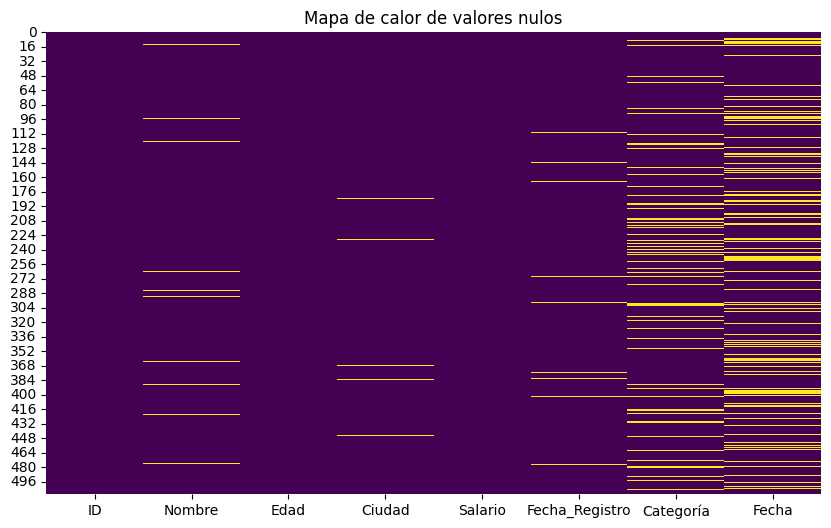

In [27]:
# Imprimir la cantidad de valores nulos por columna
print("Valores nulos por columna:")
print(df.isnull().sum())

# Mapa de calor de los valores nulos
plt.figure(figsize=(10, 6))
sns.heatmap(df.isnull(), cbar=False, cmap='viridis')
plt.title("Mapa de calor de valores nulos")
plt.show()

2. Detección de duplicados

  Podemos graficar la cantidad de filas duplicadas para tener una idea de cuántas ocurrencias repetidas hay.

Total de duplicados en 'ID': 10


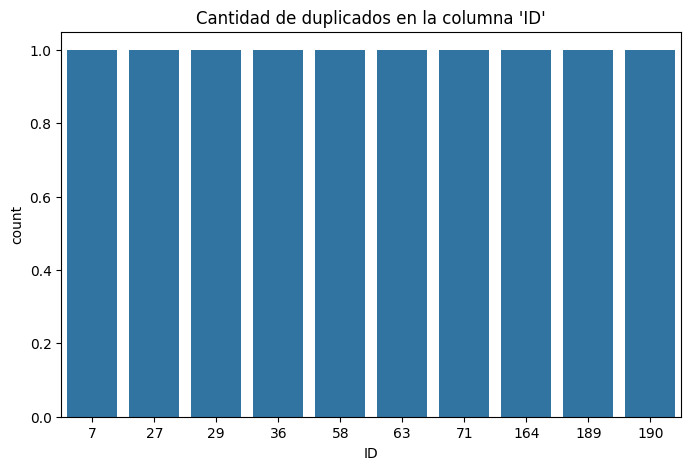

In [28]:

# Verificar duplicados
duplicados = df[df.duplicated(subset='ID')]

# Imprimir el número de duplicados en la columna 'ID'
print(f"Total de duplicados en 'ID': {duplicados.shape[0]}")

# Gráfico de barras de duplicados
plt.figure(figsize=(8, 5))
sns.countplot(x=duplicados['ID'])
plt.title("Cantidad de duplicados en la columna 'ID'")
plt.show()

3. Detección de valores atípicos (Outliers)

  Usaremos un gráfico de caja para identificar los valores atípicos, por ejemplo, en la columna Edad y Salario.

Estadísticas de la columna 'Edad':
count    510.000000
mean      50.462745
std       21.379295
min       -5.000000
25%       33.000000
50%       52.000000
75%       68.000000
max      150.000000
Name: Edad, dtype: float64
Estadísticas de la columna 'Salario':
count        510
unique       305
top       -10000
freq         105
Name: Salario, dtype: object


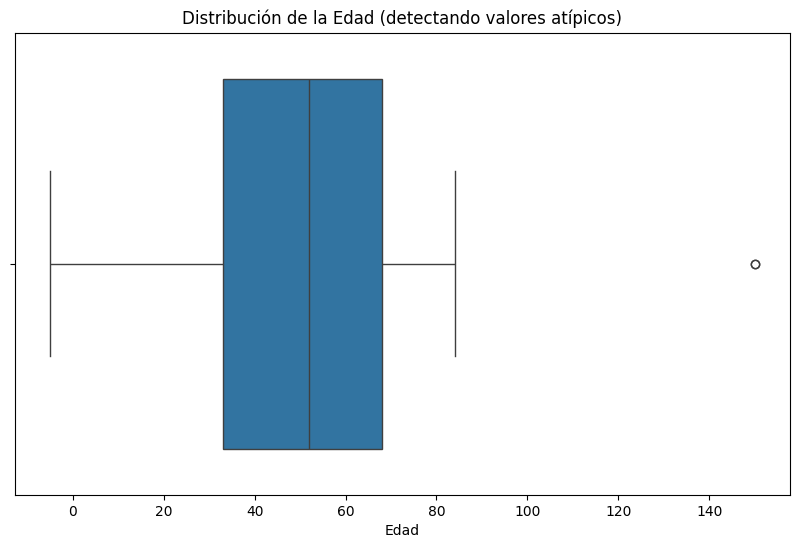

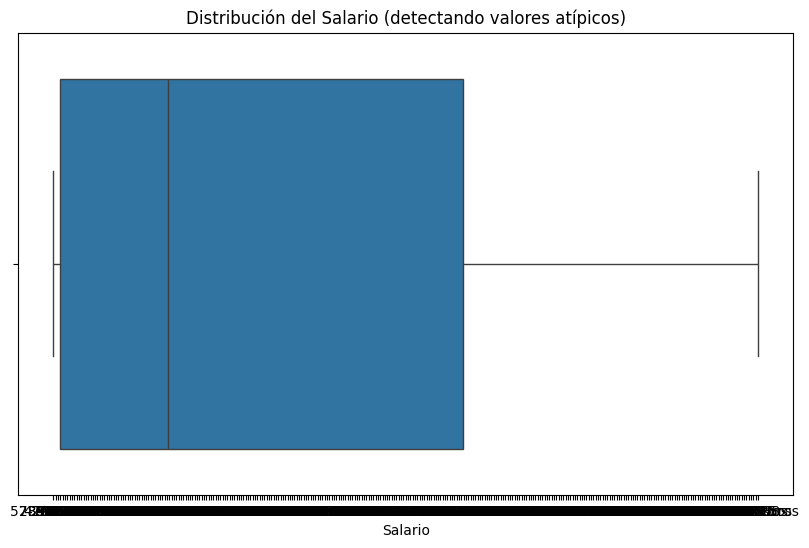

In [23]:
# Imprimir estadísticas de la columna 'Edad' para ver valores atípicos
print("Estadísticas de la columna 'Edad':")
print(df['Edad'].describe())

# Imprimir estadísticas de la columna 'Salario' para ver valores atípicos
print("Estadísticas de la columna 'Salario':")
print(df['Salario'].describe())

# Detección de valores atípicos en Edad
plt.figure(figsize=(10, 6))
sns.boxplot(x=df['Edad'])
plt.title("Distribución de la Edad (detectando valores atípicos)")
plt.show()

# Detección de valores atípicos en Salario
plt.figure(figsize=(10, 6))
sns.boxplot(x=df['Salario'])
plt.title("Distribución del Salario (detectando valores atípicos)")
plt.show()

4. Detección de incoherencias en fechas

  Podemos ver si las fechas están en un formato inconsistente utilizando un gráfico de barras con el conteo de fechas inválidas (por ejemplo, las fechas en texto).

Total de fechas inválidas: 10


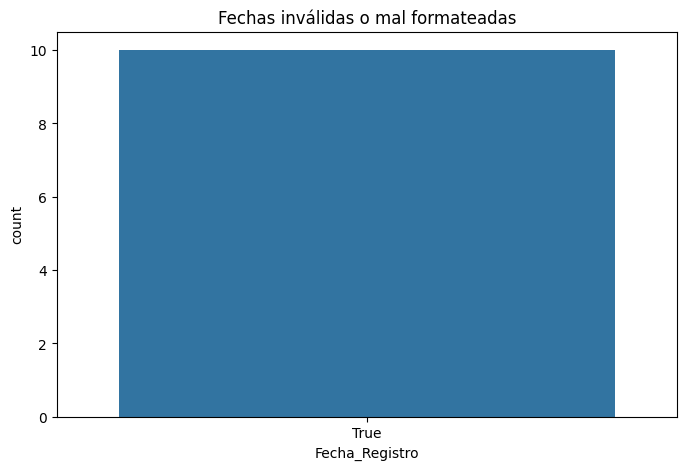

In [24]:
# Verificar formato de fecha
df['Fecha_Registro'] = pd.to_datetime(df['Fecha_Registro'], errors='coerce')
fechas_invalidas = df[df['Fecha_Registro'].isnull()]

# Imprimir la cantidad de fechas inválidas
print(f"Total de fechas inválidas: {fechas_invalidas.shape[0]}")

# Conteo de fechas inválidas
plt.figure(figsize=(8, 5))
sns.countplot(x=fechas_invalidas['Fecha_Registro'].isnull())
plt.title("Fechas inválidas o mal formateadas")
plt.show()

5. Detección de valores erróneos en el salario

  Para encontrar valores erróneos como saldos negativos, podemos usar un gráfico de barras.

In [25]:
# Detectar salarios erróneos (negativos)
salarios_erroneos = df[df['Salario'] < 0]

# Imprimir el número de salarios erróneos
print(f"Total de salarios negativos o erróneos: {salarios_erroneos.shape[0]}")

plt.figure(figsize=(10, 6))
sns.countplot(x=salarios_erroneos['Salario'])
plt.title("Salarios negativos o erróneos")
plt.show()


TypeError: '<' not supported between instances of 'str' and 'int'

6. Detección de valores nulos o vacíos en una columna

  Finalmente, podemos graficar la cantidad de celdas vacías por cada columna para tener una visión general de la falta de datos.

In [16]:
# Cargar dataset
df = pd.read_csv("dataset_sucio.csv")

# 1. Eliminar duplicados en la columna ID
df = df.drop_duplicates(subset="ID")

# 2. Manejar valores nulos
df["Nombre"].fillna("Desconocido", inplace=True)
df["Ciudad"].fillna(df["Ciudad"].mode()[0], inplace=True)  # Reemplazar por la ciudad más común
df["Fecha_Registro"] = pd.to_datetime(df["Fecha_Registro"], errors="coerce")  # Convertir a formato de fecha
df["Categoría"].fillna("Sin Categoría", inplace=True)  # Rellenar valores vacíos en Categoría

# 3. Limpiar la columna Salario
df["Salario"] = df["Salario"].astype(str).str.replace("€", "").str.replace("NaN", "0").str.replace(" Euros", "").astype(float)
df["Salario"] = df["Salario"].apply(lambda x: x if x > 0 else np.nan)  # Eliminar valores negativos

df["Salario"].fillna(df["Salario"].median(), inplace=True)  # Reemplazar NaN con la mediana

# 4. Filtrar edades inválidas
df = df[(df["Edad"] >= 18) & (df["Edad"] <= 100)]

# 5. Normalizar nombres (primera letra en mayúscula)
df["Nombre"] = df["Nombre"].str.title()

# 6. Normalizar categorías
df["Categoría"] = df["Categoría"].str.upper()
df["Categoría"].replace("SIN DATO", "SIN CATEGORÍA", inplace=True)

# 7. Corregir la columna Fecha
df["Fecha"] = pd.to_datetime(df["Fecha"], errors="coerce")  # Convertir fechas incorrectas a NaT
df["Fecha"].fillna(pd.to_datetime("2024-01-01"), inplace=True)  # Rellenar NaT con un valor por defecto

# Guardar el dataset limpio
df.to_csv("dataset_limpio.csv", index=False)

# Mostrar datos limpios
print(df.head())


   ID   Nombre  Edad     Ciudad  Salario Fecha_Registro      Categoría
0   1  Geraldo    47      Soria  50252.0     2024-09-26              C
1   2    Amado    75  Salamanca  39776.0     2022-11-12              B
3   4    Yaiza    59    Melilla  50252.0     2023-09-23              B
4   5   Estela    23       Jaén  56485.0     2024-07-22  SIN CATEGORÍA
5   6   Yésica    20   Albacete  50252.0     2023-08-31  SIN CATEGORÍA


<ipython-input-16-23f123bc4ba9>:11: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["Nombre"].fillna("Desconocido", inplace=True)
<ipython-input-16-23f123bc4ba9>:12: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try us

###Limpieza del Dataset

Este código limpia los datos en varios pasos:

- Elimina duplicados en la columna ID.

- Maneja valores nulos, rellenando con datos adecuados.

- Limpia la columna Salario, eliminando valores negativos y reemplazando NaN con la mediana.

- Filtra edades inválidas (<18 o >100).

- Normaliza nombres (primera letra en mayúscula).

- Estandariza las categorías (SIN DATO → SIN CATEGORÍA).


El dataset limpio se guarda en dataset_limpio_500.csv

In [ ]:
# Cargar dataset
df = pd.read_csv("dataset_sucio.csv")

# 1. Eliminar duplicados en la columna ID
df = df.drop_duplicates(subset="ID")

# 2. Manejar valores nulos
df["Nombre"].fillna("Desconocido", inplace=True)
df["Ciudad"].fillna(df["Ciudad"].mode()[0], inplace=True)  # Reemplazar por la ciudad más común
df["Fecha_Registro"] = pd.to_datetime(df["Fecha_Registro"], errors="coerce")  # Convertir a formato de fecha
df["Categoría"].fillna("Sin Categoría", inplace=True)  # Rellenar valores vacíos en Categoría

# 3. Limpiar la columna Salario
df["Salario"] = df["Salario"].astype(str).str.replace("€", "").str.replace("NaN", "0").astype(float)
df["Salario"] = df["Salario"].apply(lambda x: x if x > 0 else np.nan)  # Eliminar valores negativos

df["Salario"].fillna(df["Salario"].median(), inplace=True)  # Reemplazar NaN con la mediana

# 4. Filtrar edades inválidas
df = df[(df["Edad"] >= 18) & (df["Edad"] <= 100)]

# 5. Normalizar nombres (primera letra en mayúscula)
df["Nombre"] = df["Nombre"].str.title()

# 6. Normalizar categorías
df["Categoría"] = df["Categoría"].str.upper()
df["Categoría"].replace("SIN DATO", "SIN CATEGORÍA", inplace=True)

# Guardar el dataset limpio
df.to_csv("dataset_limpio.csv", index=False)

# Mostrar datos limpios
print(df.head())
